In [123]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

import sys
from StringIO import StringIO

from scipy.stats import norm, multivariate_normal, beta, binom, stats
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.special import gamma
from scipy.optimize import fmin
from scipy.interpolate import spline
from scipy.linalg import sqrtm
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

Simple graph in python

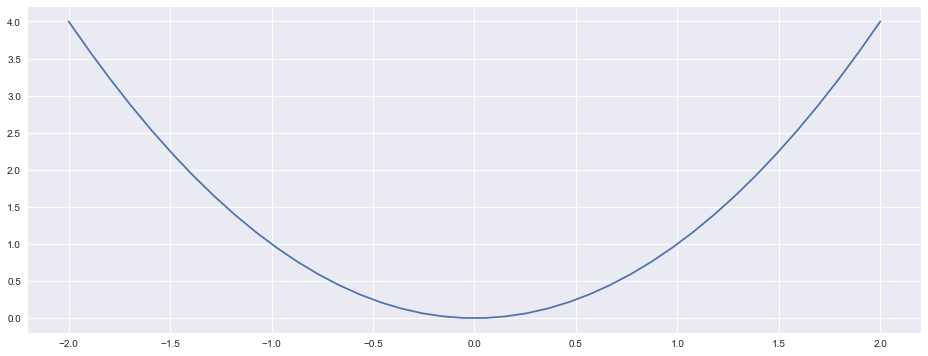

In [3]:
"""
02_SimpleGraph.py
A simple graph drawn by Python :-)
"""
x = np.linspace(-2, 2, 40)
y = x**2

plt.figure(figsize=(16,6))
plt.plot(x, y)
plt.show()

Integral of density

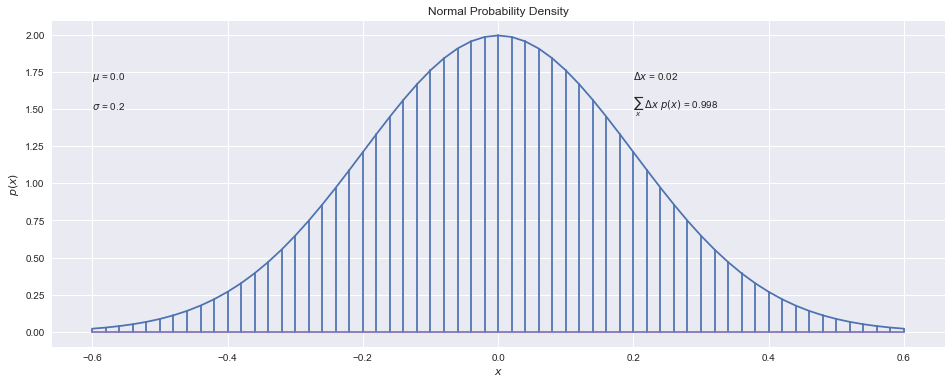

In [7]:
mean = 0.0
sd = 0.2
xlow = mean - 3.0 * sd
xhigh = mean + 3.0 * sd
dx = 0.02

x = np.arange(xlow, xhigh, dx)
gaussian_x = (1./np.sqrt(2 * np.pi * sd ** 2)) * np.exp(-0.5 * ((x - mean)/sd)**2)

plt.figure(figsize=(16, 6))
plt.plot(x, gaussian_x)
plt.stem(x, gaussian_x, markerfmt=' ')

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.title('Normal Probability Density')
# Approximate the integral as the sum of width * height for each interval.
area = np.sum(dx*gaussian_x)
# Display info in the graph.
_ = plt.text(-.6, 1.7, '$\mu$ = %s' % mean)
_ = plt.text(-.6, 1.5, '$\sigma$ = %s' % sd)
_ = plt.text(.2, 1.7, '$\Delta x$ = %s' % dx)
_ = plt.text(.2, 1.5, '$\sum_{x}$ $\Delta x$ $p(x)$ = %5.3f' % area)

Running proportion

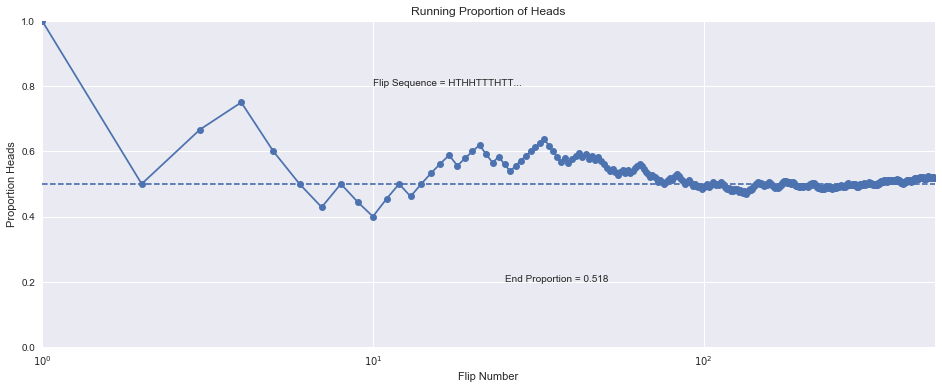

In [8]:
# Specify total number of flipping a coin
N = 500
# Generate random sample of tail and head
np.random.seed(10)
flip_sequence = np.random.choice([0, 1], p=(0.5, 0.5), size=N, replace=True)

r = np.cumsum(flip_sequence)
n = np.linspace(1, N, N)
run_prop = r / n

# Graph the running proportion:
plt.figure(figsize=(16,6)) # Brian added
plt.plot(n, run_prop, '-o', )
plt.xscale('log')  # an alternative to plot() and xscale() is semilogx()
plt.xlim(1, N)
plt.ylim(0, 1)
plt.xlabel('Flip Number')
plt.ylabel('Proportion Heads')
plt.title('Running Proportion of Heads')
# Plot a dotted horizontal line at y=.5, just as a reference line:
plt.axhline(y=.5, ls='dashed')

# Display the beginning of the flip sequence.
flipletters = ''.join(["T","H"][flip] for flip in flip_sequence[:10])

_ = plt.text(10, 0.8, 'Flip Sequence = %s...' % flipletters)
# Display the relative frequency at the end of the sequence.
_ = plt.text(25, 0.2, 'End Proportion = %s' % run_prop[-1])

Number of head in the sequence is: 259
Number of tail in the sequene is: 241


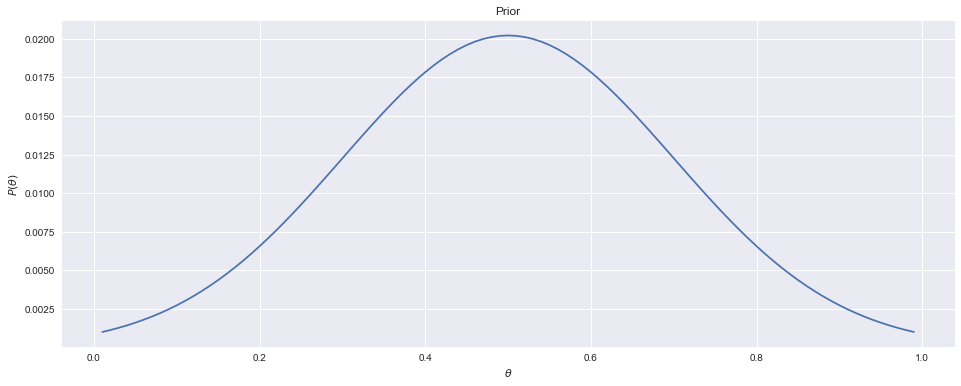

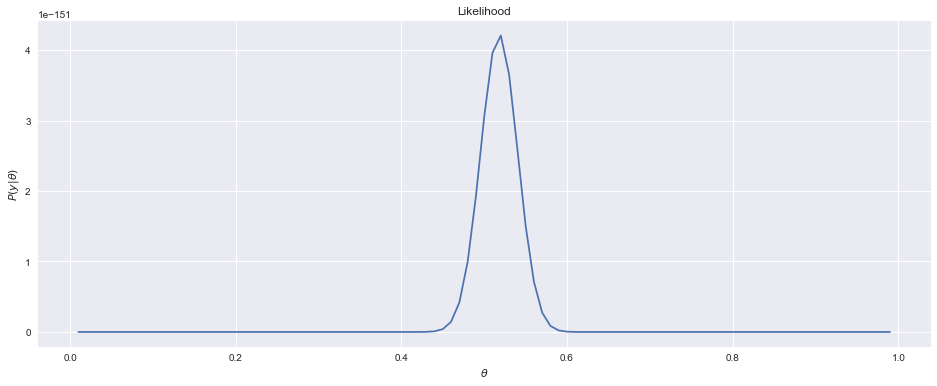

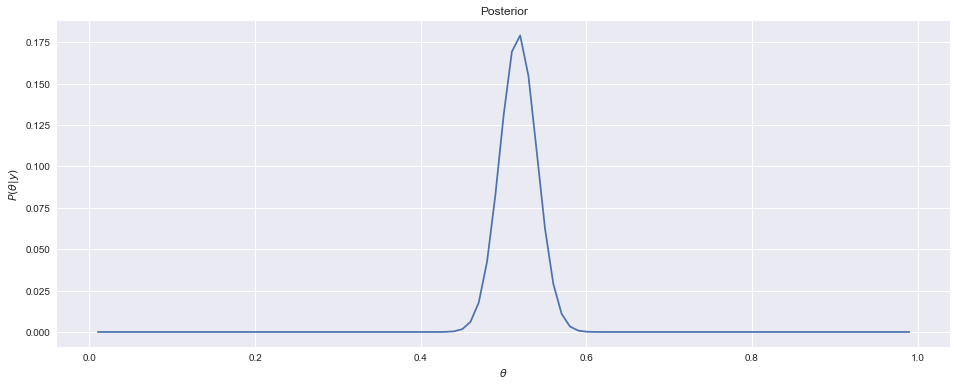

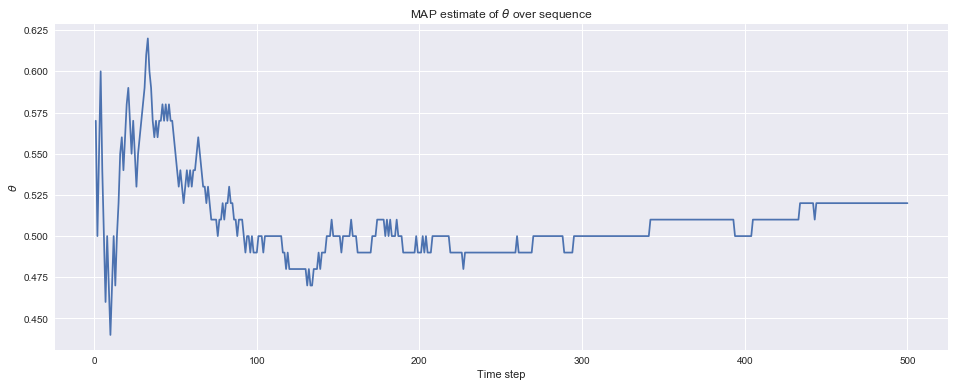

In [34]:
n_theta_vals = 99.

# Generate the a sequence of theta
theta = np.linspace(1. / (n_theta_vals+1.), n_theta_vals / (n_theta_vals + 1.), int(n_theta_vals))

# Assuming the prior probability follows a normal density function
p_theta = norm.pdf(theta, 0.5, 0.2)
p_theta = p_theta / np.sum(p_theta)

# Specify data
data = flip_sequence
head = np.sum(data)
tail = len(data) - head
print "Number of head in the sequence is:", head
print "Number of tail in the sequene is:", tail

# Calculate the Likelihood of all these priors
likelihood = theta ** head * (1 - theta) ** tail

# Calculate the posterior
posterior = likelihood * p_theta
posterior = posterior / np.sum(posterior)

# Check how posterior changes over the sequence
prior = p_theta
MAP_list = []
for obs in flip_sequence:
    temp_likelihood = theta if obs == 1 else (1.-theta)
    temp_posterior = temp_likelihood * prior
    prior = temp_posterior
    MAP_list.append(theta[np.argmax(prior)])
    
# Plot prior
plt.figure(figsize=(16,6))
plt.plot(theta, p_theta)
plt.title("Prior")
plt.xlabel("$\\theta$")
plt.ylabel("$P(\\theta)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(theta, likelihood)
plt.title("Likelihood")
plt.xlabel("$\\theta$")
plt.ylabel("$P(y|\\theta)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(theta, posterior)
plt.title("Posterior")
plt.xlabel("$\\theta$")
plt.ylabel("$P(\\theta|y)$")
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(len(MAP_list)) + 1, MAP_list)
plt.title("MAP estimate of $\\theta$ over sequence")
plt.xlabel("Time step")
plt.ylabel("$\\theta$")
plt.show()

HID of ICDF
HDI of a probability density function

In [35]:
def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

Inferring a binomial proportion via exact mathematical analysis.<br>Following the example in the textbook, the problem is described as below:

* Say we have 500 new borners, the sex of thse babies are tagged as 1 (girl) and 0 (boy)
* The prior distribution of the probablity to have new baby girl follows a uniform distribution / binomial distribution
* We are going to estimate the posterior

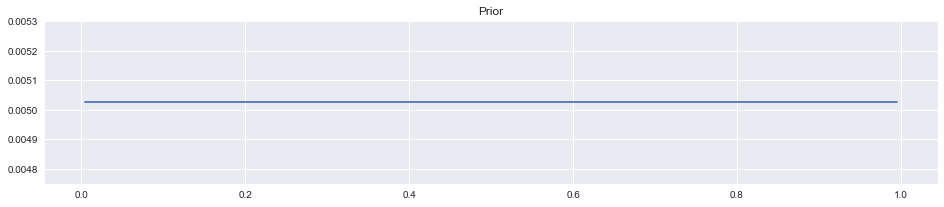

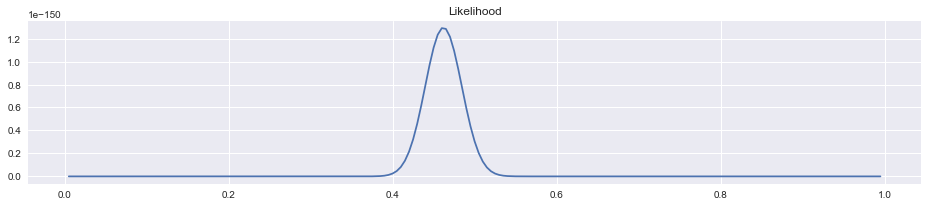

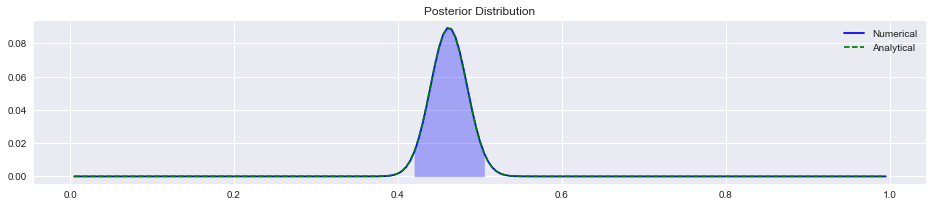

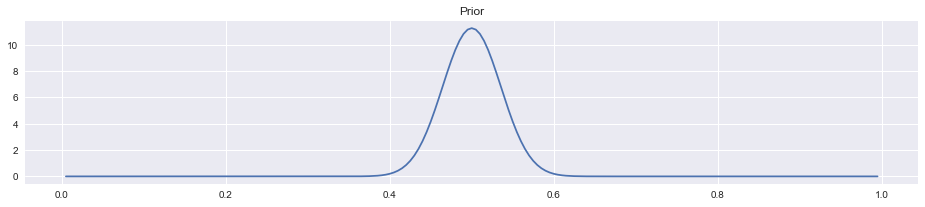

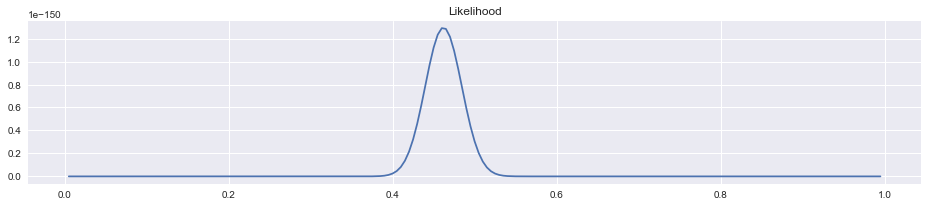

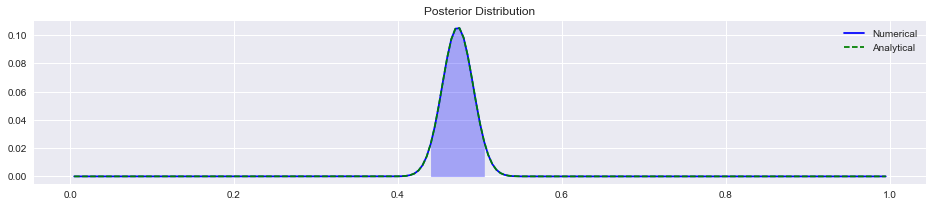

In [53]:
def binom_beta(theta, p_theta, data_vec, cred_mass=0.95, uniform = True):
    # theta and p_theta are priors has to be either uniform distribution or binomial distribution
    n_girls = np.sum(data_vec)
    n_boys = len(data_vec) - n_girls
    p_data_given_theta = theta ** n_girls * (1-theta) ** n_boys
    p_theta_given_data = p_data_given_theta * p_theta / np.sum(p_data_given_theta * p_theta)
    
    if uniform:
        post_a = n_girls
        post_b = n_boys
    else:
        def pdf_diff(t):
            a, b = t
            return np.sqrt(np.nanmean((p_theta - beta.pdf(theta, a, b))**2))
        prior_a, prior_b = fmin(pdf_diff, np.array([80, 120]), ftol=1e-8, disp=False)
        post_a = prior_a + n_girls
        post_b = prior_b + n_boys
        
    p_theta_given_data_analytical = beta.pdf(theta, post_a, post_b)
    p_theta_given_data_analytical = p_theta_given_data_analytical / np.sum(p_theta_given_data_analytical)
    intervals = HDIofICDF(beta, cred_mass, a=post_a, b=post_b)
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_theta)
    plt.title("Prior")
    plt.show()
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_data_given_theta)
    plt.title("Likelihood")
    plt.show()
    
    plt.figure(figsize=(16, 3))
    plt.plot(theta, p_theta_given_data, '-b')
    plt.plot(theta, p_theta_given_data_analytical, '--g')
    plt.legend(["Numerical", "Analytical"])
    plt.title("Posterior Distribution")
    plt.fill_between(theta, 0, p_theta_given_data, 
                     where=np.logical_and(theta > intervals[0], 
                                          theta < intervals[1]),
                     color='blue', alpha=0.3)
    plt.show()


# uniform prior
n_thetas = 199.
theta_uniform = np.linspace(1. / (n_thetas + 1.), n_thetas / (n_thetas + 1.), int(n_thetas))
p_theta_uniform = 1. / len(theta) * np.ones(len(theta))

# binomial prior
# n_thetas = 199.
theta_binom = np.linspace(1. / (n_thetas + 1.), n_thetas / (n_thetas + 1.), int(n_thetas))
p_theta_binom = beta.pdf(theta, 100, 100)
data_vec = np.random.choice([0, 1], p=(0.545, 0.455), size=500, replace=True)

binom_beta(theta_uniform, p_theta_uniform, data_vec, uniform=True)
binom_beta(theta_binom, p_theta_binom, data_vec, uniform=False)

Beta Posterior Predictions<br>
Posterior predictive check. Examine the veracity of the winning model by simulating data sampled from the winning model and see if the simulated data 'look like' the actual data

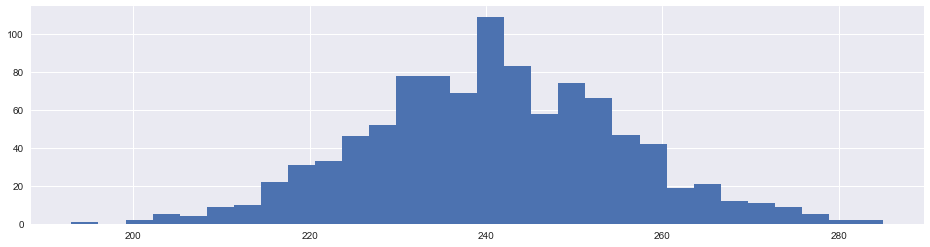

In [56]:
# Specify known values of prior and actual data
prior_a = 100
prior_b = 100
actual_data_Z = 237
actual_data_N = 500

# Compute posterior parameter values
post_a = prior_a + actual_data_Z
post_b = prior_b + actual_data_N - actual_data_Z

# Number of flips in a simulated sample should match the actual sample size
sim_sample_size = actual_data_N

# Designate an arbitrarily large number simulated samples
n_sim_samples = 1000
sim_sample_Z_record = np.zeros(n_sim_samples)
                              
for sample_idx in range(n_sim_samples):
    sample_theta = beta.rvs(post_a, post_b)
    sample_data = np.random.choice([0, 1], p=[1-sample_theta, sample_theta],
                                  size=sim_sample_size, replace=True)
    sim_sample_Z_record[sample_idx] = sum(sample_data)
    
plt.figure(figsize=(16, 4))
plt.hist(sim_sample_Z_record, bins=30)
plt.show()

Measure the speed of light by estimating parameter with nuisance parameter (Normal data with a noninformative prior distribution)

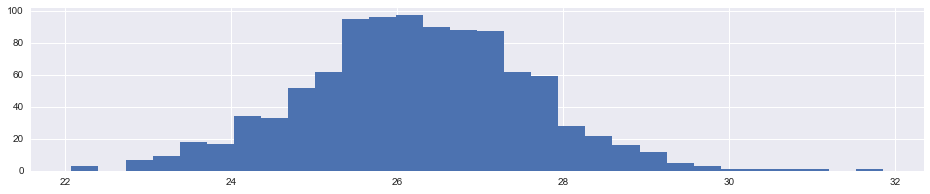

Mean is: 26.2410984051
Central interval: [23.5137291319, 28.9167151582]


In [62]:
mean = 26.2
s = 10.8
df = 65
N_simulations = 1000
sigma_2_draws = df * s**2 / np.random.chisquare(df, size=N_simulations)
mu_draws = np.zeros(N_simulations)
for i, sigma_2 in enumerate(sigma_2_draws):
    mu = np.random.normal(loc=mean, scale=np.sqrt(sigma_2 / 66.), size=1)
    mu_draws[i] = mu

plt.figure(figsize=(16, 3))
plt.hist(mu_draws, bins=30)
plt.show()

print "Mean is:", np.nanmean(mu_draws)
low_percentile = str(np.percentile(mu_draws, 2.5))
high_percentile = str(np.percentile(mu_draws, 97.5))
print "Central interval: [" + low_percentile + ", " + high_percentile + "]"

Presidential election, page 69 on Gelman's book

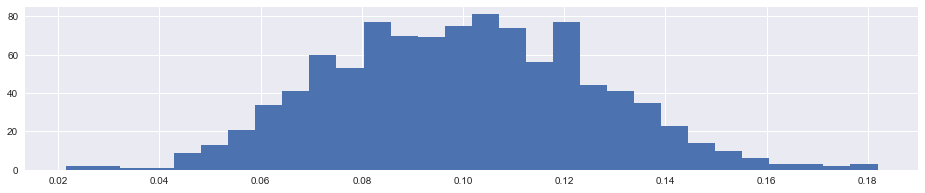

In [64]:
y_1 = 727
y_2 = 583
y_3 = 137

alpha_1 = 1
alpha_2 = 1
alpha_3 = 1

n_samples = 1000
samples = np.random.dirichlet((y_1+alpha_1, y_2+alpha_2, y_3+alpha_3), size=n_samples)

theta_1_2_diff = samples[:, 0] - samples[:, 1]
plt.figure(figsize=(16, 3))
plt.hist(theta_1_2_diff, bins=30)
plt.show()

Analysis of a bioassay experiment<br> page 75 of Gelman book

$$(x_i, n_i, y_i); \quad i = 1, \dots, k$$

where $x_i$ represents the $i$th of $k$ dose levels (often measured on a log scale) given to $n_i$ animals, of which $y_i$ subsequently respond with positive outcome. An example of real data from such an experiment is shown in Table 3.1: twenty animals were tested, five at each of four dose levels.

1. _Modeling the dose-response relation_
    * Assuming that the data points $y_i$ are binomially distributed:
    $$y_i|\theta_i\sim\textrm{Bin}(n_i, \theta_i)$$
    Please note that the binomial model will not be appropriate when the desease is contagious
    
    * Assume the _dose-response relation_ is logit model:
    $$\textrm{logit}(\theta_i)=\alpha + \beta x_i$$
    
2. In this example I tried two priors:
    1. An informative prior, which is the MLE estimate of the logistic regression
    2. A noninformative prior, which is uniform across the field

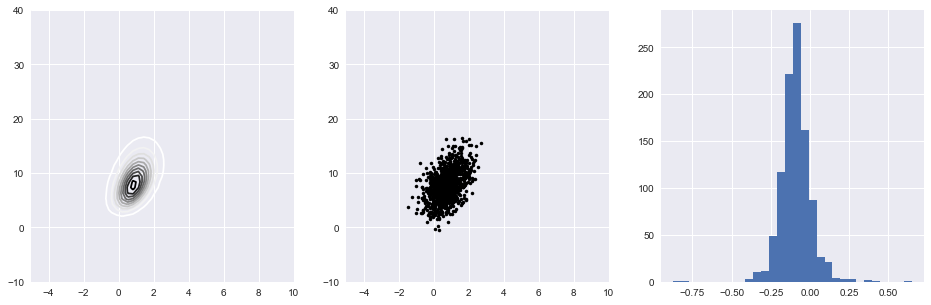

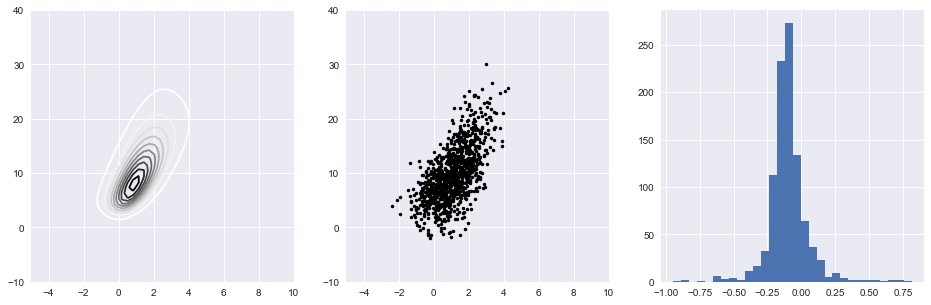

In [120]:
def bioassay():
    x = np.array([-0.86, -0.3, -0.05, 0.73])
    n = np.array([5, 5, 5, 5])
    y = np.array([0, 1, 3, 5])

    def negative_loglikelihood(params):
        alpha = params[0]
        beta = params[1]
        neg_loglikelihood = 0.
        for i in range(len(x)):
            neg_loglikelihood += (-y[i] * (alpha + beta * x[i]) + 
                                  (n[i]) * np.log(1. + np.exp(alpha + beta * x[i])))
        return neg_loglikelihood
    
    def logistic_standard_error(alpha, beta):
        loglikelihood_2nd_derivative = np.zeros((2, 2))
        for i in range(len(x)):
            multiplier = (- np.exp(alpha + beta * x[i]) / (np.exp(alpha + beta * x[i]) + 1) ** 2)
            loglikelihood_2nd_derivative[0, 0] += multiplier * n[i]
            loglikelihood_2nd_derivative[0, 1] += multiplier * x[i] * n[i]
            loglikelihood_2nd_derivative[1, 0] += multiplier * x[i] * n[i]
            loglikelihood_2nd_derivative[1, 1] += multiplier * (x[i] ** 2) * n[i]
        inv_neg_loglikelihood_2nd_derivative = np.linalg.inv(-loglikelihood_2nd_derivative)
        alpha_se = np.sqrt(inv_neg_loglikelihood_2nd_derivative[0, 0])
        beta_se = np.sqrt(inv_neg_loglikelihood_2nd_derivative[1, 1])
        return alpha_se, beta_se
    
    # MLE estimation on the logistic regression
    init_params = np.array([0.5, 0.5])
    opt_params = fmin(negative_loglikelihood, init_params, ftol=1e-8, disp=False)
    alpha_hat, beta_hat = opt_params
    alpha_hat_se, beta_hat_se = logistic_standard_error(alpha_hat, beta_hat)
    
    # Obtaining a contour plot of the joint posterior density
    alpha_range = np.linspace(-5, 10, 50)
    beta_range = np.linspace(-10, 40, 50)
    
    alpha_alpha, beta_beta = np.meshgrid(alpha_range, beta_range)
    
    alpha_norm = norm(loc=alpha_hat, scale=alpha_hat_se)
    beta_norm = norm(loc=beta_hat, scale=beta_hat_se)
    
    alpha_beta_p_space = np.column_stack((alpha_alpha.flatten(), beta_beta.flatten()))
    alpha_beta_p_space = np.column_stack((alpha_beta_p_space, np.zeros((len(alpha_beta_p_space), 2))))
    
    for i, row in enumerate(alpha_beta_p_space):
        temp_prior = alpha_norm.pdf(row[0]) * beta_norm.pdf(row[1])
        alpha_beta_p_space[i, 2] = temp_prior
        alpha_beta_p_space[i, 3] = (np.exp(-negative_loglikelihood(row)) * temp_prior)
    

    # Compute prior and joint posterior density
    prior_prior = alpha_beta_p_space[:, 2].reshape(alpha_alpha.shape)
    post_post = alpha_beta_p_space[:, 3].reshape(alpha_alpha.shape)
    max_post = np.max(post_post)
    levels = np.arange(0.05, 1.05, 0.1) * max_post
    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(131)
    plt.contour(alpha_alpha, beta_beta, post_post, levels=levels)
    
    # sampling from the joint posterior distribution
    n_samples = 1000
    marginal_alpha = np.sum(post_post, axis=0)
    marginal_alpha = marginal_alpha / np.sum(marginal_alpha)
    alpha_grid = alpha_alpha[0]
    
    def norm_alpha_pdf_diff(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(marginal_alpha) - norm.cdf(alpha_grid, a, b))**2))
    
    def norm_beta_pdf_diff(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(beta_given_alpha_sample) - norm.cdf(beta_grid, a, b))**2))
    
    alpha_mean, alpha_std = fmin(norm_alpha_pdf_diff, np.array([alpha_hat, alpha_hat_se]),
                                 ftol=1e-8, disp=False)
    samples = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        alpha_sample = norm.rvs(alpha_mean, alpha_std)
        alpha_col = np.argmin(np.abs(alpha_grid - alpha_sample))
        beta_grid = beta_beta[:, alpha_col]
        beta_given_alpha_sample = post_post[:, alpha_col].T
        beta_given_alpha_sample = beta_given_alpha_sample / np.sum(beta_given_alpha_sample)
        beta_mean, beta_std = fmin(norm_beta_pdf_diff, np.array([beta_hat, beta_hat_se]),
                                   ftol=1e-8, disp=False)
        beta_sample = norm.rvs(beta_mean, beta_std)
        samples[i] = [alpha_sample, beta_sample]
        
    fig.add_subplot(132)
    plt.plot(samples[:, 0], samples[:, 1], '.k')
    plt.xlim([-5, 10])
    plt.ylim([-10, 40])
    
    LD50 = -samples[:, 0] / samples[:, 1]
    LD50 = LD50[np.logical_and(LD50 <= 1.0, LD50 >= -1.0)]
    fig.add_subplot(133)
    plt.hist(LD50, bins=30)
    plt.show()
    
    # Compute prior and joint posterior based on uniform prior
    prior_prior_uniform = np.ones(alpha_alpha.shape) / (alpha_alpha.shape[0] * alpha_alpha.shape[1])
    prior_prior_uniform_flat = prior_prior_uniform.flatten()
    post_post_uniform_flat = np.zeros(alpha_alpha.shape).flatten()
    for i, row in enumerate(alpha_beta_p_space):
        post_post_uniform_flat[i] = (prior_prior_uniform_flat[i] * 
                                     np.exp(-negative_loglikelihood(row)))
    post_post_uniform = post_post_uniform_flat.reshape(alpha_alpha.shape)
    max_post_uniform = np.max(post_post_uniform)
    levels_uniform = np.arange(0.05, 1.05, 0.1) * max_post_uniform
    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(131)
    plt.contour(alpha_alpha, beta_beta, post_post_uniform, levels=levels_uniform)
    
    # sampling from the joint posterior distribution: prior is uniform
    marginal_alpha_uniform = np.sum(post_post_uniform, axis=0)
    marginal_alpha_uniform = marginal_alpha_uniform / np.sum(marginal_alpha_uniform)
    alpha_grid = alpha_alpha[0]
    
    def norm_alpha_pdf_diff_uniform(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(marginal_alpha_uniform) - norm.cdf(alpha_grid, a, b))**2))
    
    def norm_beta_pdf_diff_uniform(t):
        a, b = t
        return np.sqrt(np.nanmean((np.cumsum(beta_given_alpha_sample_uniform) - norm.cdf(beta_grid, a, b))**2))
    
    alpha_mean_uniform, alpha_std_uniform = fmin(norm_alpha_pdf_diff_uniform, np.array([alpha_hat, alpha_hat_se]),
                                 ftol=1e-8, disp=False)
    samples_uniform = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        alpha_sample = norm.rvs(alpha_mean_uniform, alpha_std_uniform)
        alpha_col = np.argmin(np.abs(alpha_grid - alpha_sample))
        beta_grid = beta_beta[:, alpha_col]
        beta_given_alpha_sample_uniform = post_post_uniform[:, alpha_col].T
        beta_given_alpha_sample_uniform = beta_given_alpha_sample_uniform / np.sum(beta_given_alpha_sample_uniform)
        beta_mean_uniform, beta_std_uniform = fmin(norm_beta_pdf_diff_uniform, np.array([beta_hat, beta_hat_se]),
                                   ftol=1e-8, disp=False)
        beta_sample = norm.rvs(beta_mean_uniform, beta_std_uniform)
        samples_uniform[i] = [alpha_sample, beta_sample]
        
    fig.add_subplot(132)
    plt.plot(samples_uniform[:, 0], samples_uniform[:, 1], '.k')
    plt.xlim([-5, 10])
    plt.ylim([-10, 40])
    
    LD50 =  - samples_uniform[:, 0] / samples_uniform[:, 1]
    LD50 = LD50[np.logical_and(LD50 <= 1.0, LD50 >= -1.0)]
    fig.add_subplot(133)
    plt.hist(LD50, bins=30)
    plt.show()
                
bioassay()

Hierarchical modeling

In [122]:
def tumor_rats():
    alpha_prior = 1.4
    beta_prior = 8.6
    
    alpha_post = alpha_prior + 4
    beta_post = beta_prior + 10
    
    print beta.stats(alpha_post, beta_post)
    
tumor_rats()

(array(0.225), array(0.006975000000000001))


Tumor rats modeling, continued

* The observation $y_j$ are assumed to follow the Binomial distribution:
$$y_j\sim\textrm{Bin}(n_j, \theta_j)$$

* The parameter of observation, $\theta_j$ are assumed to be independent samples from a beta distribution:
$$\theta_j\sim\textrm{Beta}(\alpha, \beta)$$

* We are going to assign noninformative prior distribution for the prior of the hyperparameters to reflect our ignorance about the unknown of the hyperparameters.

prior is uniform over:
$$(\textrm{log}(\frac{\alpha}{\beta}), \textrm{log}(\alpha+\beta))$$

In [139]:
def load_tumor():
    y = []
    n = []
    with open("tumor.txt") as f:
        for line in f.readlines():
            split_line = line.split(" ")
            for it in split_line:
                split_it = it.split("/")
                y.append(int(split_it[0]))
                try:
                    n.append(int(split_it[1]))
                except Error as e:
                    n.append(int(split_it[1][:-2]))
    return np.array(y), np.array(n)

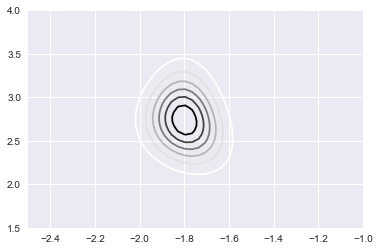

In [149]:
# please note the prior is on a transformed space of
y, n = load_tumor()

a = np.linspace(-2.5, -1, 50)
b = np.linspace(1.5, 4, 50)

aa, bb = np.meshgrid(a, b)

aa_transformed = np.exp(aa)
bb_transformed = np.exp(bb)

beta_beta = bb_transformed / (aa_transformed + 1)
alpha_alpha = aa_transformed * beta_beta

alpha_beta_prior = (alpha_alpha + beta_beta) ** (-2.5)
ab_prior = alpha_alpha * beta_beta * (alpha_alpha + beta_beta) ** (-2.5)

alpha_beta_post = np.ones(alpha_beta_prior.shape)
for y_j, n_j in zip(y, n):
    alpha_beta_post = (alpha_beta_post * gamma(alpha_alpha+beta_beta) / (gamma(alpha_alpha) * gamma(beta_beta)) *
                       gamma(alpha_alpha + y_j) * gamma(beta_beta + n_j - y_j) / gamma(alpha_alpha + beta_beta + n_j))
alpha_beta_post = alpha_beta_post * alpha_beta_prior

ab_post = alpha_beta_post * alpha_alpha * beta_beta
ab_post = ab_post / np.sum(ab_post)

plt.contour(aa, bb, ab_post)
plt.show()

In [ ]:
def gibbs_sampler(x_0, target_fun, n_sims=1000):
    pass

In [ ]:
def metropolis_hasting(x_0, target_fun, n_sims=1000):
    x_i = np.copy(x_0)
    